In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [2]:
DATA = 'switch'
dataset_dir = '../../data/'
save_dir = '../data/'
bulkseq_dataset = 'Degnorm_JS_1394ESGs.csv'
switch_dataset = "switch_genelist.csv"
meta_dataset = 'NGJ_Switches_28Sept2023.csv'

# Read Switches

In [3]:
if DATA == 'switch':
	switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
	# drop first column
	switch_df = switch_df.drop(switch_df.columns[0], axis=1)

	# switch df to dict
	switch_dict = {}
	for row in switch_df.index:
		switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Bulk Seq Dataset

In [4]:
Exp = pd.read_csv(dataset_dir + bulkseq_dataset, index_col=0).T

# bulk seq dataset is in Jane Score
print(Exp.min().min(), Exp.max().max())

0.0 28.1538


In [5]:
if DATA == 'switch':
	# transform Exp to switch
	# compare genes in switches with genes in rpkm
	switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
	# change to set
	switch_genes = set(switch_genes)
	exp_genes = set(Exp.T.index)

	# find overlapping genes
	overlapping_genes = switch_genes.intersection(exp_genes)
	print(len(switch_genes), len(exp_genes), len(overlapping_genes))

	# filter non-overlapping genes from switches
	for switch in switch_dict.keys():
		switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

	# aggregate rpkm columns using switch_dict
	Exp_new = pd.DataFrame(columns=Exp.T.columns, index=switch_dict.keys())
	for i in switch_dict.keys():
		Exp_new.loc[i] = np.mean(Exp.T.loc[switch_dict[i]].values, axis=0)

	Exp = Exp_new.T

	# save Exp
	bulkseq_dataset_name = bulkseq_dataset.split('.')[0]
	Exp.to_csv(save_dir + bulkseq_dataset_name + '_switch.csv')


5079 19501 4981


In [11]:
metadata_df = pd.read_csv(dataset_dir + meta_dataset, index_col=0)
metadata_df.head()

,Age,Surgery,Surgery.Date,Collection.Date,Endo,Endo.Case.Control,Endo.Training,Adeno,Fibroids,PCOS,...,Th2cellsIRIS3,TregsBLUEPRINT1,TregsBLUEPRINT2,TregsBLUEPRINT3,TregsFANTOM1,TregsFANTOM2,TregsFANTOM3,TregsHPCA1,TregsHPCA2,TregsHPCA3
Patient,,,,,,,,,,,,,,,,,,,,,
E01-A0001,32,PRE,no surgery date,4/28/21,1,Suspected,No,-2,-1,-2,...,0.37585,0.79800,0.6299,1.0514,0.6299,1.0514,0.4732,0.52760,0.01000,0.0100
E01-A0001,32,PRE,no surgery date,7/12/21,1,Suspected,No,-2,-1,-2,...,0.01000,1.09685,0.8891,1.1976,0.8891,1.1976,0.6971,0.33890,0.04255,0.0751
E01-A0002,34,PRE,8/12/21 0:00,8/10/21,2,Case,No,0,-1,-2,...,0.45125,1.11295,0.7453,1.3172,0.7453,1.3172,0.7453,0.37765,0.01000,0.0100
E01-A0002,34,PRE,8/12/21 0:00,8/11/21,2,Case,No,0,-1,-2,...,1.57300,2.55875,2.6503,2.8033,2.6503,2.8033,2.4903,1.25915,0.68150,0.9576
E01-A0003,39,POST,4/9/21 0:00,8/18/21,0,Other,Yes,-2,-1,-2,...,1.87580,2.68285,2.4446,2.8311,2.4446,2.8311,2.4446,1.17260,0.57660,0.5947


In [13]:
# keep only samples that pass Columbia QC
size_bf = metadata_df.shape[0]
metadata_df = metadata_df[metadata_df['Columbia QC'] == 'Pass']
size_after = metadata_df.shape[0]
print(f'Number of samples before: {size_bf}, after: {size_after}')

Number of samples before: 1394, after: 884


In [15]:
# remove duplicate kits, keep later one
size_bf = metadata_df.shape[0]
metadata_df.sort_values(by=['Clinical.QC', 'Research.QC'], inplace=True)
metadata_df.drop_duplicates(subset=['Kit'], keep='last', inplace=True)
size_after = metadata_df.shape[0]
print(f'Number of samples before: {size_bf}, after: {size_after}')

Number of samples before: 884, after: 588


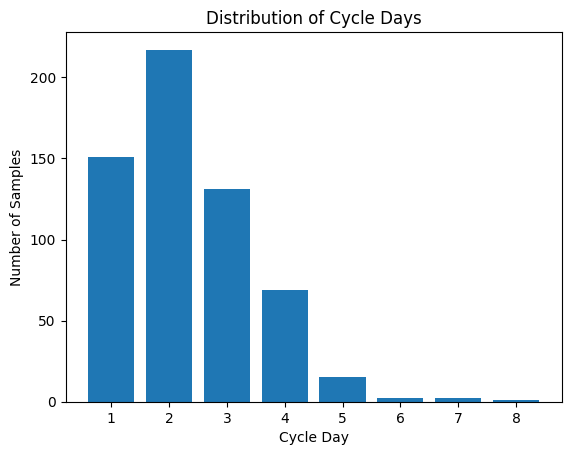

In [16]:
days_dist = dict()
for d in  metadata_df['Cycle.Day'].unique():
	days_dist[d] = (metadata_df['Cycle.Day'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Cycle Day')
plt.ylabel('Number of Samples')
plt.title('Distribution of Cycle Days')
plt.savefig('../plots/cycle_days_dist.png')

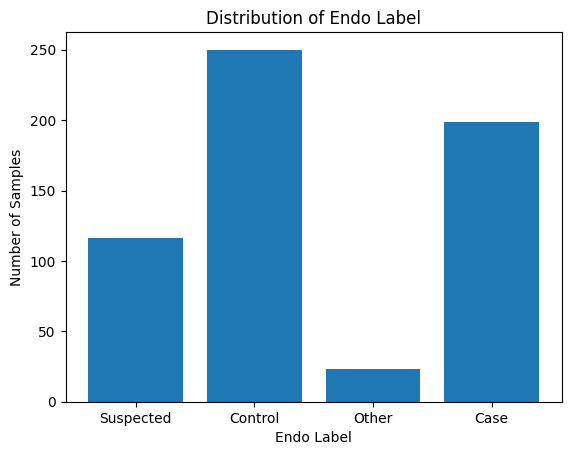

In [17]:
days_dist = dict()
for d in  metadata_df['Endo.Case.Control'].unique():
	days_dist[d] = (metadata_df['Endo.Case.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Endo Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Endo Label')
plt.savefig('../plots/endo_label_dist.png')

In [18]:
# # drop rows with negative day values
# metadata_df = metadata_df[metadata_df['Cycle.Day'] > 0]
# # drop rows with day > 5
# metadata_df = metadata_df[metadata_df['Cycle.Day'] <= 5]
# # drop rows with other endo labels
# metadata_df = metadata_df[metadata_df['Endo.Case.Control'] != 'Other']
# # add column to encode endo label to 0 and 1
# metadata_df['Endo.Case.Control'] = metadata_df['Endo.Case.Control'].map({'Case': 1, 'Control': 0, 'Suspected': 0.5})

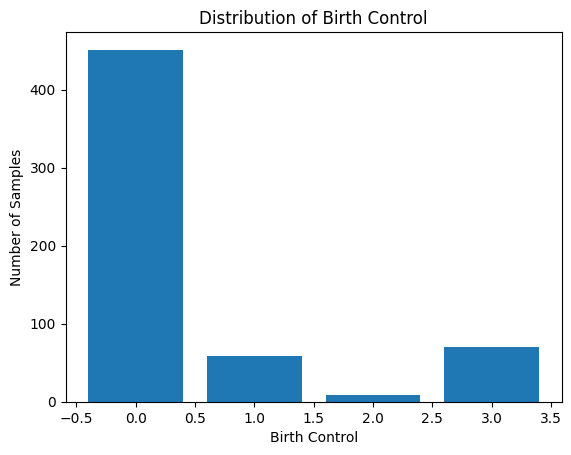

In [19]:
# plot dist of birth control
birth_map = {0: 0, 2: 1, 5: 2, 6: 2, 7: 1, 4:3, -3:3, 3:3, -1:3, -2:3, 1:3, 8:3}
days_dist = dict()
days_dist[0] = 0
days_dist[1] = 0
days_dist[2] = 0
days_dist[3] = 0

for d in  metadata_df['Birth.Control'].unique():
	label = birth_map[d]
	days_dist[label] += (metadata_df['Birth.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Birth Control')
plt.ylabel('Number of Samples')
plt.title('Distribution of Birth Control')
plt.savefig('../plots/birth_control_dist_4groups.png')

In [20]:
# add column to encode Birth.Control
metadata_df['Birth.Control'] = metadata_df['Birth.Control'].map(birth_map)

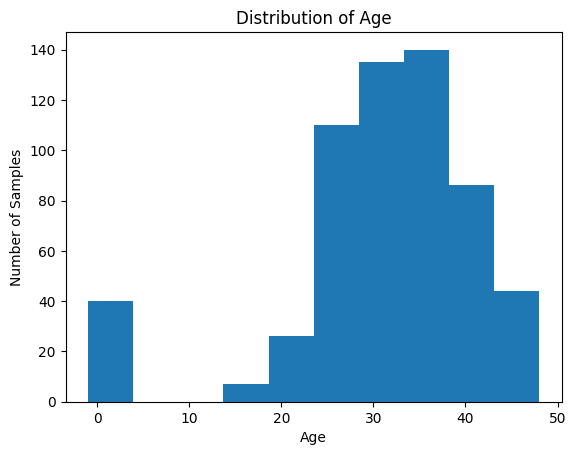

In [21]:
# plot dist of age
plt.hist(metadata_df['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('../plots/age_dist.png')

In [22]:
# add column to bucket age into 6 groups
age_binned = []
for age in metadata_df['Age']:
	if age == -1:
		age_binned.append(-1)
	elif age <= 29:
		age_binned.append(0)
	elif age <= 35:
		age_binned.append(1)
	elif age <= 40:
		age_binned.append(2)
	else:
		age_binned.append(3)

metadata_df['Age.Binned'] = age_binned

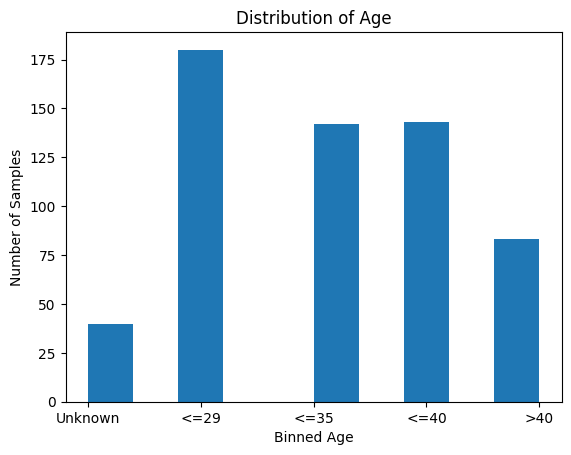

In [23]:
# replot dist of age
plt.hist(metadata_df['Age.Binned'])
plt.xticks([-1, 0, 1, 2, 3], ['Unknown', '<=29', '<=35', '<=40', '>40'])
plt.xlabel('Binned Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('../plots/age_binned_dist_5groups.png')

In [24]:
metaData_col = ['ESG', 'Cycle.Day', 'Endo.Case.Control', 'Age.Binned', 'Cycle', 'Birth.Control']
metaData = metadata_df[metaData_col]
metaData.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control
Patient,,,,,,
E01-A0001,ESG1075,4,Suspected,1,a,0
E01-A0013,ESG1111,1,Control,1,b,0
E01-A0022,ESG1117,3,Control,2,a,1
E01-A0001,ESG1122,1,Suspected,1,a,0
E01-A0001,ESG1123,2,Suspected,1,a,0


In [25]:
df = metaData.merge(Exp, right_index=True, left_on='ESG')
df.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control,aDC_HPCA_1,aDC_HPCA_2,aDC_HPCA_3,aDC_IRIS_1,...,Th2 cells_IRIS_3,Tregs_BLUEPRINT_1,Tregs_BLUEPRINT_2,Tregs_BLUEPRINT_3,Tregs_FANTOM_1,Tregs_FANTOM_2,Tregs_FANTOM_3,Tregs_HPCA_1,Tregs_HPCA_2,Tregs_HPCA_3
Patient,,,,,,,,,,,,,,,,,,,,,
E01-A0001,ESG1075,4,Suspected,1,a,0,1.8844,1.86912,1.86912,1.858853,...,1.079394,1.168168,0.993711,1.39086,0.993711,1.39086,1.3128,1.016933,0.66783,1.0138
E01-A0013,ESG1111,1,Control,1,b,0,2.45225,2.69303,2.69303,2.656916,...,1.374087,1.862109,1.625956,1.95778,1.625956,1.95778,1.57051,1.105758,0.71262,1.138155
E01-A0022,ESG1117,3,Control,2,a,1,2.822825,2.90746,2.90746,2.980105,...,1.763056,2.205277,2.186267,2.64226,2.186267,2.64226,2.078148,1.505317,1.21378,1.474055
E01-A0001,ESG1122,1,Suspected,1,a,0,3.157662,3.75105,3.75105,3.212779,...,1.647756,2.282514,1.977878,2.49454,1.977878,2.49454,1.981648,1.3916,0.87262,1.375273
E01-A0001,ESG1123,2,Suspected,1,a,0,2.745838,2.88935,2.88935,2.732968,...,1.6221,2.003341,1.984911,2.348527,1.984911,2.348527,1.944929,1.602517,1.20233,1.533373


In [26]:
print("Dataset size:", df.shape)

Dataset size: (588, 495)


In [27]:
# save df to file
df.to_csv(f'{save_dir}/exp_metadata_cleaned_js_{DATA}.csv', sep='\t')

In [28]:
# split data by age
df_age_le = df[df['Age.Binned'] == 0]
df_age_le.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele29_{DATA}.csv', sep='\t')
print("Age <= 29, dataset size:", df_age_le.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 1]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele35_{DATA}.csv', sep='\t')
print("29 < Age <= 35, dataset size:", df_age_ge.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 2]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele40_{DATA}.csv', sep='\t')
print("35 < Age <= 40, dataset size:", df_age_ge.shape)

# split data by age
df_age_ge = df[df['Age.Binned'] == 3]
df_age_ge.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agege40_{DATA}.csv', sep='\t')
print("Age > 40, dataset size:", df_age_ge.shape)

Age <= 29, dataset size: (180, 495)
29 < Age <= 35, dataset size: (142, 495)
35 < Age <= 40, dataset size: (143, 495)
Age > 40, dataset size: (83, 495)


In [30]:
# split data by endo label
df_case = df[df['Endo.Case.Control'] == 'Case']
df_case.to_csv(f'{save_dir}/exp_metadata_cleaned_js_case_{DATA}.csv', sep='\t')

df_control = df[df['Endo.Case.Control'] == 'Control']
df_control.to_csv(f'{save_dir}/exp_metadata_cleaned_js_control_{DATA}.csv', sep='\t')

df_suspect = df[df['Endo.Case.Control'] == 'Suspected']
df_suspect.to_csv(f'{save_dir}/exp_metadata_cleaned_js_sus_{DATA}.csv', sep='\t')

print(df_case.head()['Endo.Case.Control'], df_control.head()['Endo.Case.Control'], df_suspect.head()['Endo.Case.Control'])

Patient
E01-A0043    Case
E01-A0043    Case
E01-A0036    Case
E01-A0062    Case
E01-A0047    Case
Name: Endo.Case.Control, dtype: object Patient
E01-A0013    Control
E01-A0022    Control
H01-A0167    Control
H01-A0169    Control
H01-A0156    Control
Name: Endo.Case.Control, dtype: object Patient
E01-A0001    Suspected
E01-A0001    Suspected
E01-A0001    Suspected
E01-A0001    Suspected
E01-A0001    Suspected
Name: Endo.Case.Control, dtype: object


In [31]:
# split data by birth control
df_bc_0 = df[df['Birth.Control'] == 0]
df_bc_0.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcno_{DATA}.csv', sep='\t')

df_bc_1 = df[df['Birth.Control'] == 1]
df_bc_1.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcep_{DATA}.csv', sep='\t')

df_bc_2 = df[df['Birth.Control'] == 2]
df_bc_2.to_csv(f'{save_dir}/exp_metadata_cleaned_js_bcp_{DATA}.csv', sep='\t')

print(df_bc_0.head()['Birth.Control'], df_bc_1.head()['Birth.Control'], df_bc_2.head()['Birth.Control'])

Patient
E01-A0001    0
E01-A0013    0
E01-A0001    0
E01-A0001    0
E01-A0001    0
Name: Birth.Control, dtype: int64 Patient
E01-A0022    1
E01-A0017    1
E01-A0043    1
E01-A0043    1
E01-A0022    1
Name: Birth.Control, dtype: int64 Patient
E01-A0026    2
E01-A0026    2
E01-A0026    2
E01-A0071    2
E01-A0071    2
Name: Birth.Control, dtype: int64
